In [3]:
# Examining Shape of Relationship Between Basis Motifs and Outcomes of Interest

import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import pearsonr, spearmanr, shapiro
from scipy.spatial.distance import cdist
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 

output_dir = 'motif-outcome_analysis'
os.makedirs(output_dir, exist_ok=True)

def load_basis_motif_results(save_dir="saved_results"):
    """Load basis motif results from saved pickle file"""
    basis_motif_path = os.path.join(save_dir, "basis_motif_results.pkl")
    if os.path.exists(basis_motif_path):
        print(f"Loading basis motif results from {basis_motif_path}...")
        with open(basis_motif_path, 'rb') as f:
            basis_motif_results = pickle.load(f)
        print("Successfully loaded basis motif results!")
        return basis_motif_results
    else:
        print(f"Error: Basis motif results not found at {basis_motif_path}")
        return None

def load_trajectory_data(results_dir='energy_landscape_results'):
    """Load energy landscape trajectory data"""
    results_path = os.path.join(results_dir, 'trajectory_data.pkl')
    if os.path.exists(results_path):
        with open(results_path, 'rb') as f:
            trajectory_data = pickle.load(f)
        print(f"Successfully loaded trajectory data from {results_path}")
        return trajectory_data
    else:
        print(f"Error: Trajectory data not found at {results_path}")
        return None

def load_energy_metrics(metrics_path='efficiency_analysis_results/energy_landscape_metrics_age_adjusted.csv'):
    """Load age-adjusted energy landscape metrics"""
    if os.path.exists(metrics_path):
        print(f"Loading metrics from {metrics_path}...")
        metrics_df = pd.read_csv(metrics_path)
        print(f"Successfully loaded metrics for {metrics_df.shape[0]} participants")
        return metrics_df
    else:
        print(f"Error: Metrics file not found at {metrics_path}")
        return None

def extract_basis_motif_expressions(landscape_results, basis_metadata):
    print("Extracting basis motif expression by participant...")
    from scipy.spatial.distance import cdist

    umap_embedding = landscape_results.get('umap_embedding')
    metadata = landscape_results.get('metadata', [])

    if umap_embedding is None or not metadata:
        print("Error: Missing required data in landscape results")
        return None

    # Find all TCOA participants
    tcoa_indices = []
    tcoa_participant_ids = set()

    for i, meta in enumerate(metadata):
        participant_id = meta.get('participant_id', '')
        if participant_id.startswith('4'):
            tcoa_indices.append(i)
            tcoa_participant_ids.add(participant_id)

    print(f"Found {len(tcoa_participant_ids)} unique TCOA participants")

    # Check if we have basis_idx in the metadata
    basis_indices = {}
    missing_basis_idx = False

    for cluster, meta in basis_metadata.items():
        if 'centroid_idx' in meta:
            basis_indices[cluster] = meta['centroid_idx']
        else:
            missing_basis_idx = True
            print(f"Warning: Missing centroid_idx for cluster {cluster}")

    if missing_basis_idx and basis_indices:
        print("Some basis motif indices are missing, but will proceed with available ones")
    elif missing_basis_idx and not basis_indices:
        print("All basis motif indices are missing. Trying an alternative approach...")
        for cluster, meta in basis_metadata.items():
            if 'member_indices' in meta:
                basis_indices[cluster] = meta['member_indices'][0]
                print(f"Using first member of cluster {cluster} as proxy for centroid")

    if not basis_indices:
        print("Error: Could not find any basis motif indices")
        return None

    # Calculate expression
    basis_expression_by_participant = {p: {} for p in tcoa_participant_ids}

    for cluster, basis_idx in basis_indices.items():
        basis_point = umap_embedding[basis_idx].reshape(1, -1)
        for participant_id in tcoa_participant_ids:
            participant_indices = [i for i, meta in enumerate(metadata) if meta.get('participant_id', '') == participant_id]
            if participant_indices:
                participant_points = umap_embedding[participant_indices]
                distances = cdist(basis_point, participant_points, metric='euclidean')
                avg_distance = np.mean(distances)
                expression = 1.0 / (avg_distance + 1e-10)
                basis_expression_by_participant[participant_id][cluster] = expression

    # Normalize expression values per participant
    for participant_id in basis_expression_by_participant:
        values = list(basis_expression_by_participant[participant_id].values())
        if values:
            min_val = min(values)
            max_val = max(values)
            if max_val > min_val:
                for cluster in basis_expression_by_participant[participant_id]:
                    value = basis_expression_by_participant[participant_id][cluster]
                    normalized = (value - min_val) / (max_val - min_val)
                    basis_expression_by_participant[participant_id][cluster] = normalized

    data_rows = []
    for participant_id, expression_dict in basis_expression_by_participant.items():
        row = {'participant_id': participant_id}
        for cluster, expression in expression_dict.items():
            row[f'basis_motif_{cluster}'] = expression
        data_rows.append(row)

    basis_expression_df = pd.DataFrame(data_rows)
    print(f"Created basis expression DataFrame with {basis_expression_df.shape[0]} participants")
    return basis_expression_df

def prepare_analysis_dataframe(basis_expression_df, metrics_df):
    print("Preparing analysis DataFrame...")
    if basis_expression_df is None or metrics_df is None:
        print("Error: Missing basis expression or metrics data")
        return None

    basis_expression_df = basis_expression_df.copy()
    metrics_df = metrics_df.copy()
    basis_expression_df['participant_id'] = basis_expression_df['participant_id'].astype(str)
    metrics_df['participant_id'] = metrics_df['participant_id'].astype(str)

    analysis_df = pd.merge(basis_expression_df, metrics_df, on='participant_id', how='inner')
    print(f"Created analysis DataFrame with {analysis_df.shape[0]} participants and {analysis_df.shape[1]} columns")

    analysis_df.to_csv(os.path.join(output_dir, 'basis_motif_analysis_data.csv'), index=False)
    print(f"Saved analysis DataFrame to {os.path.join(output_dir, 'basis_motif_analysis_data.csv')}")

    return analysis_df

def calculate_adj_r2(r2, n, k):
    """Calculates Adjusted R-squared"""
    if n - k - 1 == 0:
        return np.nan # Avoid division by zero
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

def calculate_aic(n, mse, k):
    """Calculates Akaike Information Criterion"""
    if mse <= 0: # Avoid log(0) or log(neg)
        return np.inf
    # k = number of parameters including intercept and variance
    num_params = k + 1
    return n * np.log(mse) + 2 * num_params

def calculate_bic(n, mse, k):
    """Calculates Bayesian Information Criterion"""
    if mse <= 0:
        return np.inf
    # k = number of parameters including intercept and variance
    num_params = k + 1
    return n * np.log(mse) + num_params * np.log(n)


def analyze_relationships(analysis_df, outcome_metrics):
    print("\nAnalyzing relationships between basis motifs and outcome metrics...")

    basis_motif_cols = [col for col in analysis_df.columns if col.startswith('basis_motif_')]
    if not basis_motif_cols:
        print("Error: No basis motif columns found in analysis DataFrame")
        return None

    # Store detailed results including model comparison metrics
    results = defaultdict(lambda: {'shapiro_p': None, 'predictors': {}})

    for outcome in outcome_metrics:
        if outcome not in analysis_df.columns:
            print(f"Warning: Outcome metric '{outcome}' not found in data. Skipping.")
            continue

        print(f"\n--- Analyzing Outcome: {outcome} ---")
        outcome_values = analysis_df[outcome].dropna().values
        if len(outcome_values) >= 3:
            _, p_val = shapiro(outcome_values)
            results[outcome]['shapiro_p'] = p_val
            print(f"  Shapiro-Wilk p-value for {outcome}: {p_val:.4e}")
        else:
            print(f"  Not enough non-NA data for Shapiro-Wilk test for {outcome}")

        # Create subplots for this outcome
        n_predictors = len(basis_motif_cols)
        if n_predictors == 0: continue
        n_cols = min(3, n_predictors)
        n_rows = (n_predictors + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
        axes = axes.flatten() # Flatten to easily iterate

        plot_idx = 0 # Keep track of which axis to plot on

        for i, col in enumerate(basis_motif_cols):
            valid_data = analysis_df[[col, outcome]].dropna()
            n = len(valid_data)

            # Need at least N > degree+1 points for polynomial fits + metrics
            if n < 5: # Need n > k+1 for AIC/BIC with k=3 (cubic) + variance = 4 params
                print(f"  Skipping {col} vs {outcome}: Not enough data points ({n}) for robust analysis.")
                # Turn off unused axes if we skip
                if i < len(axes): axes[i].axis('off')
                continue

            ax = axes[plot_idx]
            plot_idx += 1

            # Data for fitting
            x = valid_data[col].values.reshape(-1, 1)
            y = valid_data[outcome].values

            # Store metrics for this predictor-outcome pair
            model_metrics = {}

            # --- Model Fitting and Metrics ---
            models = {'Linear': 1, 'Quadratic': 2, 'Cubic': 3}
            colors = {'Linear': 'blue', 'Quadratic': 'red', 'Cubic': 'green'}

            for name, degree in models.items():
                # Fit model
                model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
                model.fit(x, y)
                y_pred = model.predict(x)

                # Calculate metrics
                r2 = r2_score(y, y_pred)
                mse = mean_squared_error(y, y_pred)
                k_adj = degree # Number of predictor terms (excluding intercept) for Adj R2
                k_aic_bic = degree + 1 # Number of coefficients (incl. intercept) for AIC/BIC param count

                adj_r2 = calculate_adj_r2(r2, n, k_adj)
                aic = calculate_aic(n, mse, k_aic_bic)
                bic = calculate_bic(n, mse, k_aic_bic)

                model_metrics[name] = {'r2': r2, 'adj_r2': adj_r2, 'aic': aic, 'bic': bic, 'mse': mse, 'model': model}


            # --- Find Best Model based on criteria ---
            # Lower AIC/BIC is better, Higher Adj R2 is better
            best_adj_r2_model = max(model_metrics, key=lambda k: model_metrics[k]['adj_r2'] if pd.notna(model_metrics[k]['adj_r2']) else -np.inf)
            best_aic_model = min(model_metrics, key=lambda k: model_metrics[k]['aic'] if pd.notna(model_metrics[k]['aic']) else np.inf)
            best_bic_model = min(model_metrics, key=lambda k: model_metrics[k]['bic'] if pd.notna(model_metrics[k]['bic']) else np.inf)

            # Store predictor results
            results[outcome]['predictors'][col] = {
                'metrics': model_metrics,
                'best_adj_r2': best_adj_r2_model,
                'best_aic': best_aic_model,
                'best_bic': best_bic_model,
                'n': n
            }

            # --- Plotting ---
            ax.scatter(x, y, alpha=0.6, label='Data')
            x_sorted = np.sort(x, axis=0) # For smooth lines

            for name, metrics in model_metrics.items():
                model = metrics['model']
                y_pred_sorted = model.predict(x_sorted)
                label = (f"{name}\n"
                         f"  Adj R²={metrics['adj_r2']:.3f}\n"
                         f"  AIC={metrics['aic']:.2f}\n"
                         f"  BIC={metrics['bic']:.2f}")

                # Highlight best models? Optional: Use thicker lines or different style
                linewidth = 1.5
                linestyle = '-'
                # Example: Highlight best BIC model
                if name == best_bic_model:
                     linewidth = 2.5
                     # linestyle = '--' # Or change style

                ax.plot(x_sorted, y_pred_sorted, label=label, color=colors[name],
                        linewidth=linewidth, linestyle=linestyle)

            ax.set_title(f"{col}\nvs {outcome} (n={n})")
            ax.set_xlabel(col)
            ax.set_ylabel(outcome)
            ax.legend(fontsize='small') # Adjust fontsize if labels overlap
            ax.grid(True, linestyle='--', alpha=0.6)


        # Turn off any remaining unused axes
        for k in range(plot_idx, len(axes)):
            axes[k].axis('off')

        fig.suptitle(f'Model Fits for Outcome: {outcome}', fontsize=16, y=1.02) # Adjust y position if needed
        plt.tight_layout()
        plot_path = os.path.join(output_dir, f'{outcome}_relationships.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight') # Use bbox_inches='tight'
        plt.close(fig)
        print(f"  Saved plot: {plot_path}")


    # Save detailed results
    results_path = os.path.join(output_dir, 'relationship_analysis_results.pkl')
    # Convert defaultdict back to dict for pickling if needed (though usually works)
    with open(results_path, 'wb') as f:
        pickle.dump(dict(results), f)
    print(f"\nDetailed analysis results (including metrics) saved to {results_path}")

    return dict(results)


def create_summary_report(results, analysis_df):
    if not results:
        print("No results to summarize")
        return

    output_path = os.path.join(output_dir, 'summary_report.txt')
    print(f"\nCreating summary report: {output_path}...")

    with open(output_path, 'w') as f:
        f.write("BASIS MOTIF RELATIONSHIP ANALYSIS SUMMARY\n")
        f.write("=======================================\n\n")
        f.write(f"Analysis included {analysis_df.shape[0]} participants after merging.\n\n")

        for outcome, outcome_data in results.items():
            f.write(f"--- Outcome Metric: {outcome} ---\n")
            shapiro_p = outcome_data.get('shapiro_p')
            if shapiro_p is not None:
                f.write(f"  Shapiro-Wilk Normality Test p-value: {shapiro_p:.4e}")
                if shapiro_p < 0.05:
                    f.write(" (Indicates non-normality)\n")
                else:
                    f.write(" (Does not reject normality)\n")
            else:
                f.write("  Shapiro-Wilk test not performed (insufficient data).\n")

            f.write("\n  Model Selection Summary per Predictor:\n")
            if not outcome_data.get('predictors'):
                 f.write("    No valid predictor analysis performed for this outcome.\n")
                 continue

            f.write("    Predictor | n | Best Model (Adj R²) | Best Model (AIC) | Best Model (BIC)\n")
            f.write("    ----------|---|---------------------|------------------|-----------------\n")

            predictors_sorted = sorted(outcome_data['predictors'].keys()) # Sort for consistent order
            for predictor in predictors_sorted:
                pred_data = outcome_data['predictors'][predictor]
                n_val = pred_data['n']
                best_adj_r2 = pred_data['best_adj_r2']
                best_aic = pred_data['best_aic']
                best_bic = pred_data['best_bic']
                # Get metrics for the best BIC model as an example summary value
                bic_val = pred_data['metrics'][best_bic]['bic']
                adjr2_val = pred_data['metrics'][best_adj_r2]['adj_r2']
                aic_val = pred_data['metrics'][best_aic]['aic']

                f.write(f"    {predictor:<10}| {n_val:<3} | {best_adj_r2:<20}| {best_aic:<16} | {best_bic:<15}\n")
                # Optional: Add the metric value for the best model
                # f.write(f"    (Adj R²={adjr2_val:.3f}) (AIC={aic_val:.2f}) (BIC={bic_val:.2f})\n")


            f.write("\n") # Space before next outcome

    print(f"Summary report saved to {output_path}")

def main():
    basis_motif_results = load_basis_motif_results()
    if basis_motif_results is None:
        return

    landscape_results = load_trajectory_data()
    if landscape_results is None:
        return

    metrics_df = load_energy_metrics()
    if metrics_df is None:
        return

    print("\nBasis motif results keys:", list(basis_motif_results.keys()))
    # Safely access basis_metadata
    basis_metadata = basis_motif_results.get('basis_metadata', {})
    if not basis_metadata:
         print("Warning: 'basis_metadata' key not found or is empty in basis_motif_results.")
         # Depending on your needs, you might want to return here or handle differently
         # return

    basis_expression_df = extract_basis_motif_expressions(
        landscape_results, basis_metadata
    )

    if basis_expression_df is None or basis_expression_df.empty:
        print("Error: Could not extract basis motif expressions for participants")
        return

    analysis_df = prepare_analysis_dataframe(basis_expression_df, metrics_df)
    if analysis_df is None or analysis_df.empty:
        print("Error: No data available for analysis after merging.")
        return

    outcome_metrics = [
        'EMD_age_adjusted',
        'LZ_age_adjusted',
        'TransitionEntropy_age_adjusted',
        'Lyapunov_age_adjusted'
        # Add any other relevant outcome columns from your metrics_df
    ]

    # Filter metrics to only those actually present in the final dataframe
    existing_metrics = [m for m in outcome_metrics if m in analysis_df.columns]
    if not existing_metrics:
        print(f"Error: None of the specified outcome metrics ({outcome_metrics}) were found in the final analysis DataFrame columns: {analysis_df.columns.tolist()}")
        return

    print(f"\nAnalyzing relationships for existing metrics: {existing_metrics}")

    # Run the analysis which now includes model comparison metrics
    results = analyze_relationships(analysis_df, existing_metrics)

    # Create the updated summary report
    if results:
        create_summary_report(results, analysis_df)

    print("\nAnalysis complete! Check the output directory for plots, data, results pickle, and summary report.")

if __name__ == "__main__":
    main()

Loading basis motif results from saved_results/basis_motif_results.pkl...
Successfully loaded basis motif results!
Successfully loaded trajectory data from energy_landscape_results/trajectory_data.pkl
Loading metrics from efficiency_analysis_results/energy_landscape_metrics_age_adjusted.csv...
Successfully loaded metrics for 12 participants

Basis motif results keys: ['fc_motifs', 'metadata', 'feature_vectors', 'feature_vectors_scaled', 'output_dir', 'pca', 'pca_transformed', 'variance_ratio', 'cumulative_variance', 'distance_matrix', 'best_k', 'best_modularity', 'cluster_labels', 'n_clusters', 'basis_motifs', 'basis_metadata', 'cluster_members', 'cluster_correlation_matrices', 'variance_explained']
Extracting basis motif expression by participant...
Found 12 unique TCOA participants
Created basis expression DataFrame with 12 participants
Preparing analysis DataFrame...
Created analysis DataFrame with 12 participants and 26 columns
Saved analysis DataFrame to motif-outcome_analysis/bas

In [6]:
# Predicting Emergent Properties (Efficiency + Complexity) Based on Basis Motif Expression: 
# Random Forest with Stability Assessment (using Permutation Importance) --> computes average importance scores using 5 repeats

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed
import cupy as cp  # Optional: for GPU-accelerated array operations

# Create output directory
output_dir = 'non_linear_motif_analysis'
os.makedirs(output_dir, exist_ok=True)

# Load data prepared by your script
data_path = '/home/cerna3/neuroconn/Analyses_2/motif-outcome-analysis/basis_motif_analysis_data.csv'
analysis_df = pd.read_csv(data_path)
print(f"Loaded data with {analysis_df.shape[0]} participants and {analysis_df.shape[1]} columns")

# Define predictors and outcomes
basis_motif_cols = [col for col in analysis_df.columns if col.startswith('basis_motif_')]
outcome_metrics = ['EMD_age_adjusted', 'LZ_age_adjusted',
                   'TransitionEntropy_age_adjusted', 'Lyapunov_age_adjusted']

def analyze_with_random_forest_permutation_importance(X, y, outcome_name, n_bootstrap=1000,
                                                        use_cupy=False, base_seed=42):
    """
    Random Forest analysis with bootstrap and permutation importance.
    For each bootstrap iteration, trains a Random Forest on a bootstrapped sample,
    computes permutation importance (n_repeats=5) on the original data, and stores
    the predictions and r2 score. Averaging across iterations gives a stable
    estimate of feature importance.
    """
    n_samples, n_features = X.shape
    
    # Baseline performance using LOOCV (parallelized)
    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=2,
                               random_state=base_seed, n_jobs=-1)
    loo_preds = cross_val_predict(rf, X, y, cv=LeaveOneOut(), n_jobs=-1)
    base_r2 = r2_score(y, loo_preds)
    base_rmse = np.sqrt(mean_squared_error(y, loo_preds))
    
    def single_bootstrap_iteration(i, X, y, seed):
        # Bootstrap sampling with a local RNG for reproducibility
        local_rng = np.random.RandomState(seed + i)
        indices = local_rng.choice(len(y), size=len(y), replace=True)
        X_boot, y_boot = X[indices], y[indices]
        
        # Train a Random Forest on the bootstrap sample
        rf_boot = RandomForestRegressor(n_estimators=100, min_samples_leaf=2,
                                        random_state=seed, n_jobs=-1)
        rf_boot.fit(X_boot, y_boot)
        
        # Get predictions on the original dataset and compute r2 score
        iteration_predictions = rf_boot.predict(X).flatten()
        iteration_r2 = r2_score(y, iteration_predictions)
        
        # Compute permutation importance on the original dataset
        perm_import = permutation_importance(rf_boot, X, y, n_repeats=5,
                                             scoring='r2', random_state=seed,
                                             n_jobs=-1)
        importance_scores = perm_import.importances_mean  # Averaged over repeats
        return importance_scores, iteration_predictions, iteration_r2

    # Run bootstrap iterations in parallel
    results_list = Parallel(n_jobs=-1)(
        delayed(single_bootstrap_iteration)(i, X, y, base_seed)
        for i in range(n_bootstrap)
    )
    
    # Aggregate permutation importance scores and bootstrap predictions
    importance_accum = np.zeros(n_features)
    bootstrap_predictions = np.zeros((n_bootstrap, len(y)))
    bootstrap_r2 = np.zeros(n_bootstrap)
    
    for i, (importance_scores, preds, r2_val) in enumerate(results_list):
        importance_accum += importance_scores
        bootstrap_predictions[i] = preds
        bootstrap_r2[i] = r2_val
    
    avg_importance = importance_accum / n_bootstrap

    # Calculate prediction intervals (optionally using CuPy for GPU acceleration)
    if use_cupy:
        bootstrap_predictions_gpu = cp.asarray(bootstrap_predictions)
        lower_pred = cp.percentile(bootstrap_predictions_gpu, 2.5, axis=0).get()
        upper_pred = cp.percentile(bootstrap_predictions_gpu, 97.5, axis=0).get()
        mean_pred = cp.mean(bootstrap_predictions_gpu, axis=0).get()
    else:
        lower_pred = np.percentile(bootstrap_predictions, 2.5, axis=0)
        upper_pred = np.percentile(bootstrap_predictions, 97.5, axis=0)
        mean_pred = np.mean(bootstrap_predictions, axis=0)

    # Calculate feature rankings and get top motifs
    feature_importances = list(zip(basis_motif_cols, avg_importance))
    sorted_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    top_motifs = [int(col.replace('basis_motif_', '')) for col, _ in sorted_importances[:3]]
    
    results = {
        'outcome': outcome_name,
        'avg_permutation_importance': avg_importance,
        'feature_importances': feature_importances,
        'sorted_importances': sorted_importances,
        'top_3_motifs': top_motifs,
        'base_r2': base_r2,
        'base_rmse': base_rmse,
        'bootstrap_r2_mean': np.mean(bootstrap_r2),
        'bootstrap_r2_std': np.std(bootstrap_r2),
        'predictions': {
            'mean': mean_pred,
            'lower': lower_pred,
            'upper': upper_pred,
            'actual': y
        }
    }
    return results

# Analyze each outcome metric
results = {}
for outcome in outcome_metrics:
    if outcome not in analysis_df.columns:
        print(f"Skipping {outcome} - not found in data")
        continue

    # Prepare data: drop missing values for predictors and outcome
    valid_data = analysis_df[basis_motif_cols + [outcome]].dropna()
    if len(valid_data) < 5:
        print(f"Skipping {outcome} - insufficient data")
        continue

    X = valid_data[basis_motif_cols].values
    y = valid_data[outcome].values

    # Scale predictors
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Run analysis with bootstrap and permutation importance (set use_cupy=True to enable GPU acceleration)
    print(f"Analyzing {outcome} with Random Forest, bootstrap, and permutation importance...")
    results[outcome] = analyze_with_random_forest_permutation_importance(X_scaled, y, outcome,
                                                                         n_bootstrap=1000,
                                                                         use_cupy=False)

    # Visualize average permutation importance scores
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(results[outcome]['avg_permutation_importance'])
    plt.barh(range(len(sorted_idx)),
             results[outcome]['avg_permutation_importance'][sorted_idx],
             align='center')
    plt.yticks(range(len(sorted_idx)),
               [basis_motif_cols[i].replace('basis_motif_', 'Motif ') for i in sorted_idx])
    plt.title(f'Average Permutation Importance - {outcome}')
    plt.xlabel('Average Permutation Importance (R2)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{outcome}_rf_permutation_importance.png'), dpi=300)
    plt.close()

    # Prediction visualization with uncertainty intervals
    plt.figure(figsize=(10, 6))
    preds = results[outcome]['predictions']
    sort_idx = np.argsort(preds['actual'])
    x = np.arange(len(sort_idx))
    plt.plot(x, preds['actual'][sort_idx], 'o-', label='Actual')
    plt.plot(x, preds['mean'][sort_idx], 's--', label='Predicted')
    plt.fill_between(x, preds['lower'][sort_idx], preds['upper'][sort_idx],
                     alpha=0.2, label='95% Prediction Interval')
    plt.title(f'Predictions with Uncertainty - {outcome}')
    plt.xlabel('Participant (sorted)')
    plt.ylabel(outcome)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{outcome}_rf_predictions.png'), dpi=300)
    plt.close()
    
# Final print statement
print(f"Results saved to {os.path.abspath(output_dir)}")

# Save results in a structured format (pickle)
results_file = os.path.join(output_dir, 'rf_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)
print(f"Structured results saved to {results_file}")

# Generate text report for human readability
import os
import numpy as np
from scipy.stats import spearmanr

def format_results(outcome_name, outcome_results, basis_motif_cols):
    output_str = f"Results for {outcome_name}:\n"
    output_str += f"  Baseline R-squared (LOOCV): {outcome_results['base_r2']:.4f}\n"
    output_str += f"  Baseline RMSE (LOOCV): {outcome_results['base_rmse']:.4f}\n"
    output_str += f"  Bootstrap R-squared (mean): {outcome_results['bootstrap_r2_mean']:.4f}\n"
    output_str += f"  Bootstrap R-squared (std): {outcome_results['bootstrap_r2_std']:.4f}\n\n"

    output_str += "  Average Permutation Importances:\n"
    for i, feature in enumerate(basis_motif_cols):
        output_str += f"    {feature}: Importance = {outcome_results['avg_permutation_importance'][i]:.4f}\n"

    # Compute an overall standard deviation and flag features exceeding 2 * std as 'stable'
    overall_std = np.std(outcome_results['avg_permutation_importance'])
    stable_features = [basis_motif_cols[i] for i, imp in enumerate(outcome_results['avg_permutation_importance']) if imp > 2 * overall_std]
    output_str += f"\n  Stable Features (Importance > 2 * overall std [{2*overall_std:.4f}]): {stable_features}\n\n"

    # Add top 3 motifs information
    output_str += f"  Top 3 motifs: {outcome_results['top_3_motifs']}\n\n"

    mean_predictions = outcome_results['predictions']['mean']
    lower_predictions = outcome_results['predictions']['lower']
    upper_predictions = outcome_results['predictions']['upper']
    actual_values = outcome_results['predictions']['actual']

    output_str += "  First 5 Predictions and Actual Values:\n"
    for i in range(min(5, len(actual_values))):
        output_str += (f"    Actual: {actual_values[i]:.4f}, Predicted: {mean_predictions[i]:.4f}, "
                       f"95% CI: [{lower_predictions[i]:.4f}, {upper_predictions[i]:.4f}]\n")

    correlation, p_value = spearmanr(actual_values, mean_predictions)
    output_str += f"\n  Spearman Correlation between Actual and Predicted: {correlation:.4f}, p-value: {p_value:.4f}\n\n"

    return output_str

# Write results for all outcomes to a text file
with open(os.path.join(output_dir, 'results.txt'), 'w') as f:
    f.write("Summary of Results for all Outcomes:\n\n")
    for outcome_name, outcome_results in results.items():
        f.write(format_results(outcome_name, outcome_results, basis_motif_cols))
        f.write("-" * 40 + "\n\n")
        
# Final print statement
print(f"Results text file saved to {os.path.abspath(output_dir)}/results.txt")

Loaded data with 12 participants and 26 columns
Analyzing EMD_age_adjusted with Random Forest, bootstrap, and permutation importance...
Analyzing LZ_age_adjusted with Random Forest, bootstrap, and permutation importance...
Analyzing TransitionEntropy_age_adjusted with Random Forest, bootstrap, and permutation importance...
Analyzing Lyapunov_age_adjusted with Random Forest, bootstrap, and permutation importance...
Results saved to /home/cerna3/neuroconn/Analyses_2/non_linear_motif_analysis
Structured results saved to non_linear_motif_analysis/rf_results.pkl
Results text file saved to /home/cerna3/neuroconn/Analyses_2/non_linear_motif_analysis/results.txt



TOP PREDICTIVE BASIS MOTIFS HEATMAP GENERATOR
Loading trajectory data from energy_landscape_results/trajectory_data.pkl...
Successfully loaded trajectory data
Loading basis motif identities from basis_motif_identities/basis_motif_identities.pkl...
Successfully loaded 11 basis motif identities
Found full matching scores for 11 motifs
Loading Random Forest results from non_linear_motif_analysis/rf_results.pkl...
Successfully loaded results for 4 outcomes: EMD_age_adjusted, LZ_age_adjusted, TransitionEntropy_age_adjusted, Lyapunov_age_adjusted
  Top 3 motifs for EMD_age_adjusted: [9, 0, 2]
  Top 3 motifs for LZ_age_adjusted: [10, 3, 4]
  Top 3 motifs for TransitionEntropy_age_adjusted: [9, 7, 5]
  Top 3 motifs for Lyapunov_age_adjusted: [10, 7, 2]
Trying to load practice hours from practice_hours.csv...
File not found: practice_hours.csv
Trying to load practice hours from practice_hours.xlsx...
File not found: practice_hours.xlsx
Trying to load practice hours from Participant Experience 

Enter a number (1-3):  3



Showing top 3 motifs for each outcome.

How many network identities would you like to show for each motif?


Enter a number (1-3):  3



Showing top 3 network identities for each motif.
Creating top motifs heatmap...
Saved heatmap to: top_motifs_analysis/top_motifs_expression_heatmap.png
Creating outcome-specific heatmaps...
Saved EMD_age_adjusted heatmap to: top_motifs_analysis/top_motifs_EMD_age_adjusted.png
Saved LZ_age_adjusted heatmap to: top_motifs_analysis/top_motifs_LZ_age_adjusted.png
Saved TransitionEntropy_age_adjusted heatmap to: top_motifs_analysis/top_motifs_TransitionEntropy_age_adjusted.png
Saved Lyapunov_age_adjusted heatmap to: top_motifs_analysis/top_motifs_Lyapunov_age_adjusted.png
Creating combined 2x2 heatmap figure...
Saved combined heatmap to: top_motifs_analysis/combined_top_motifs_heatmap.png

HEATMAP GENERATION COMPLETE
Results saved to /home/cerna3/neuroconn/Analyses_2/top_motifs_analysis


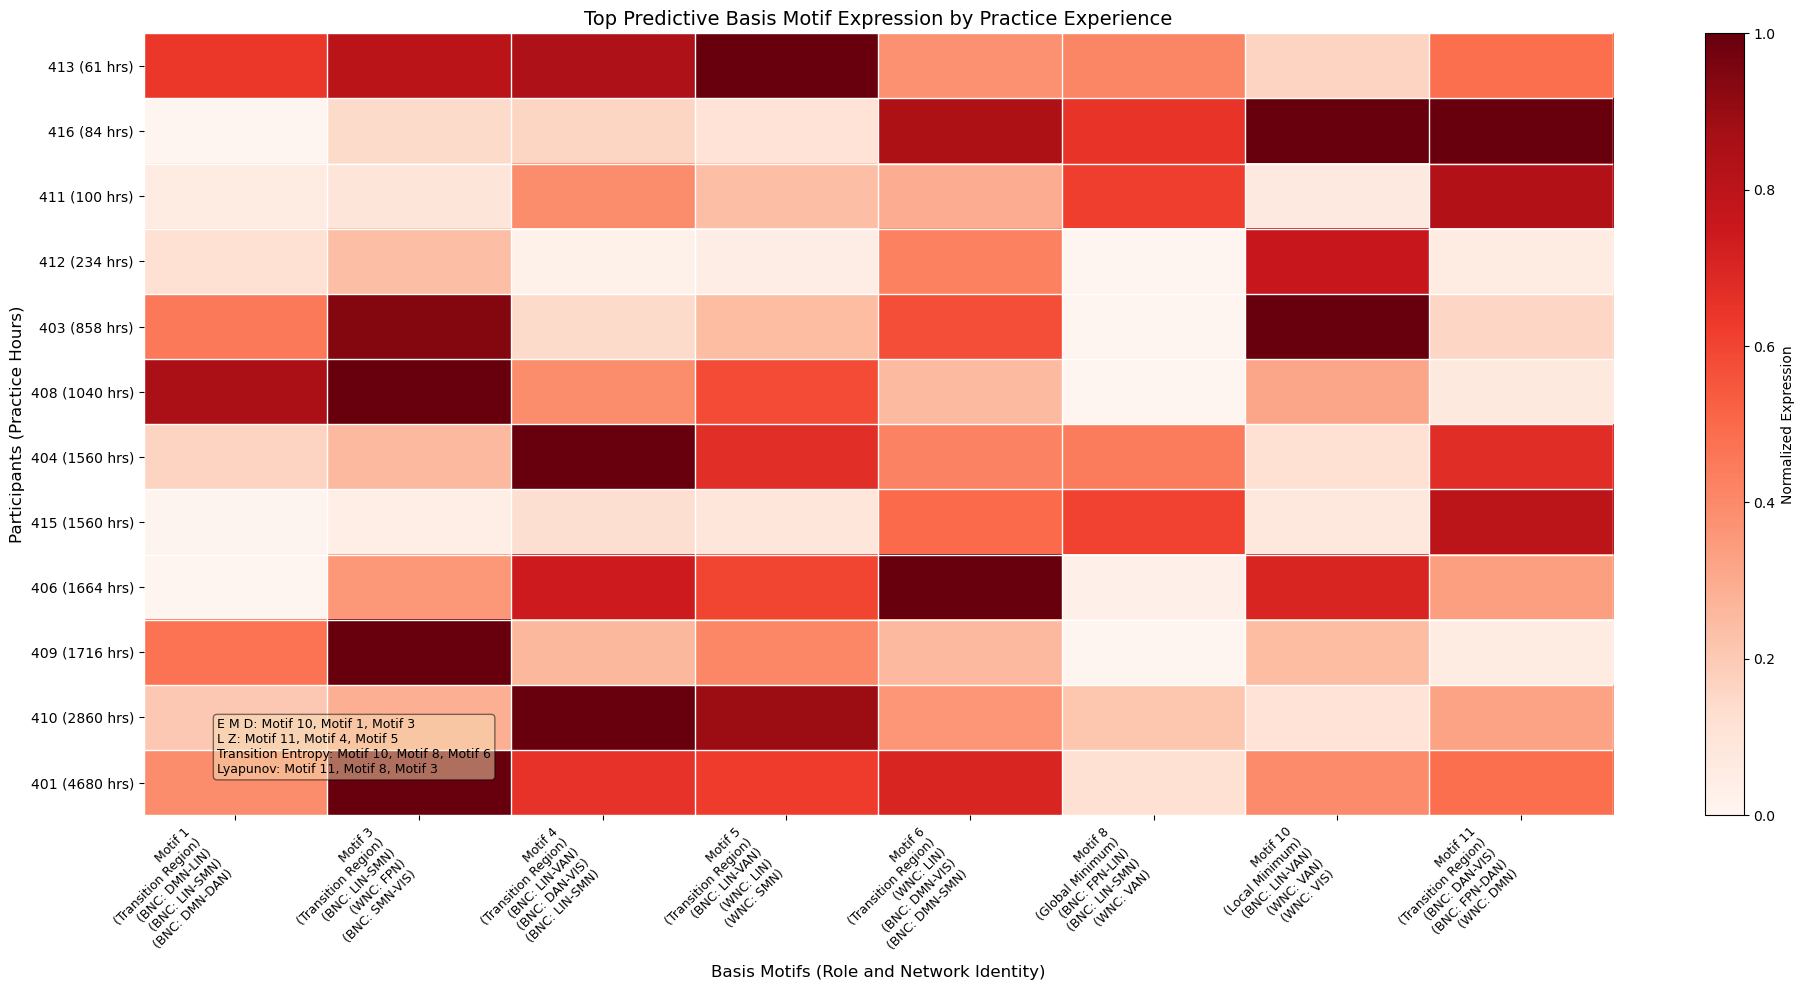

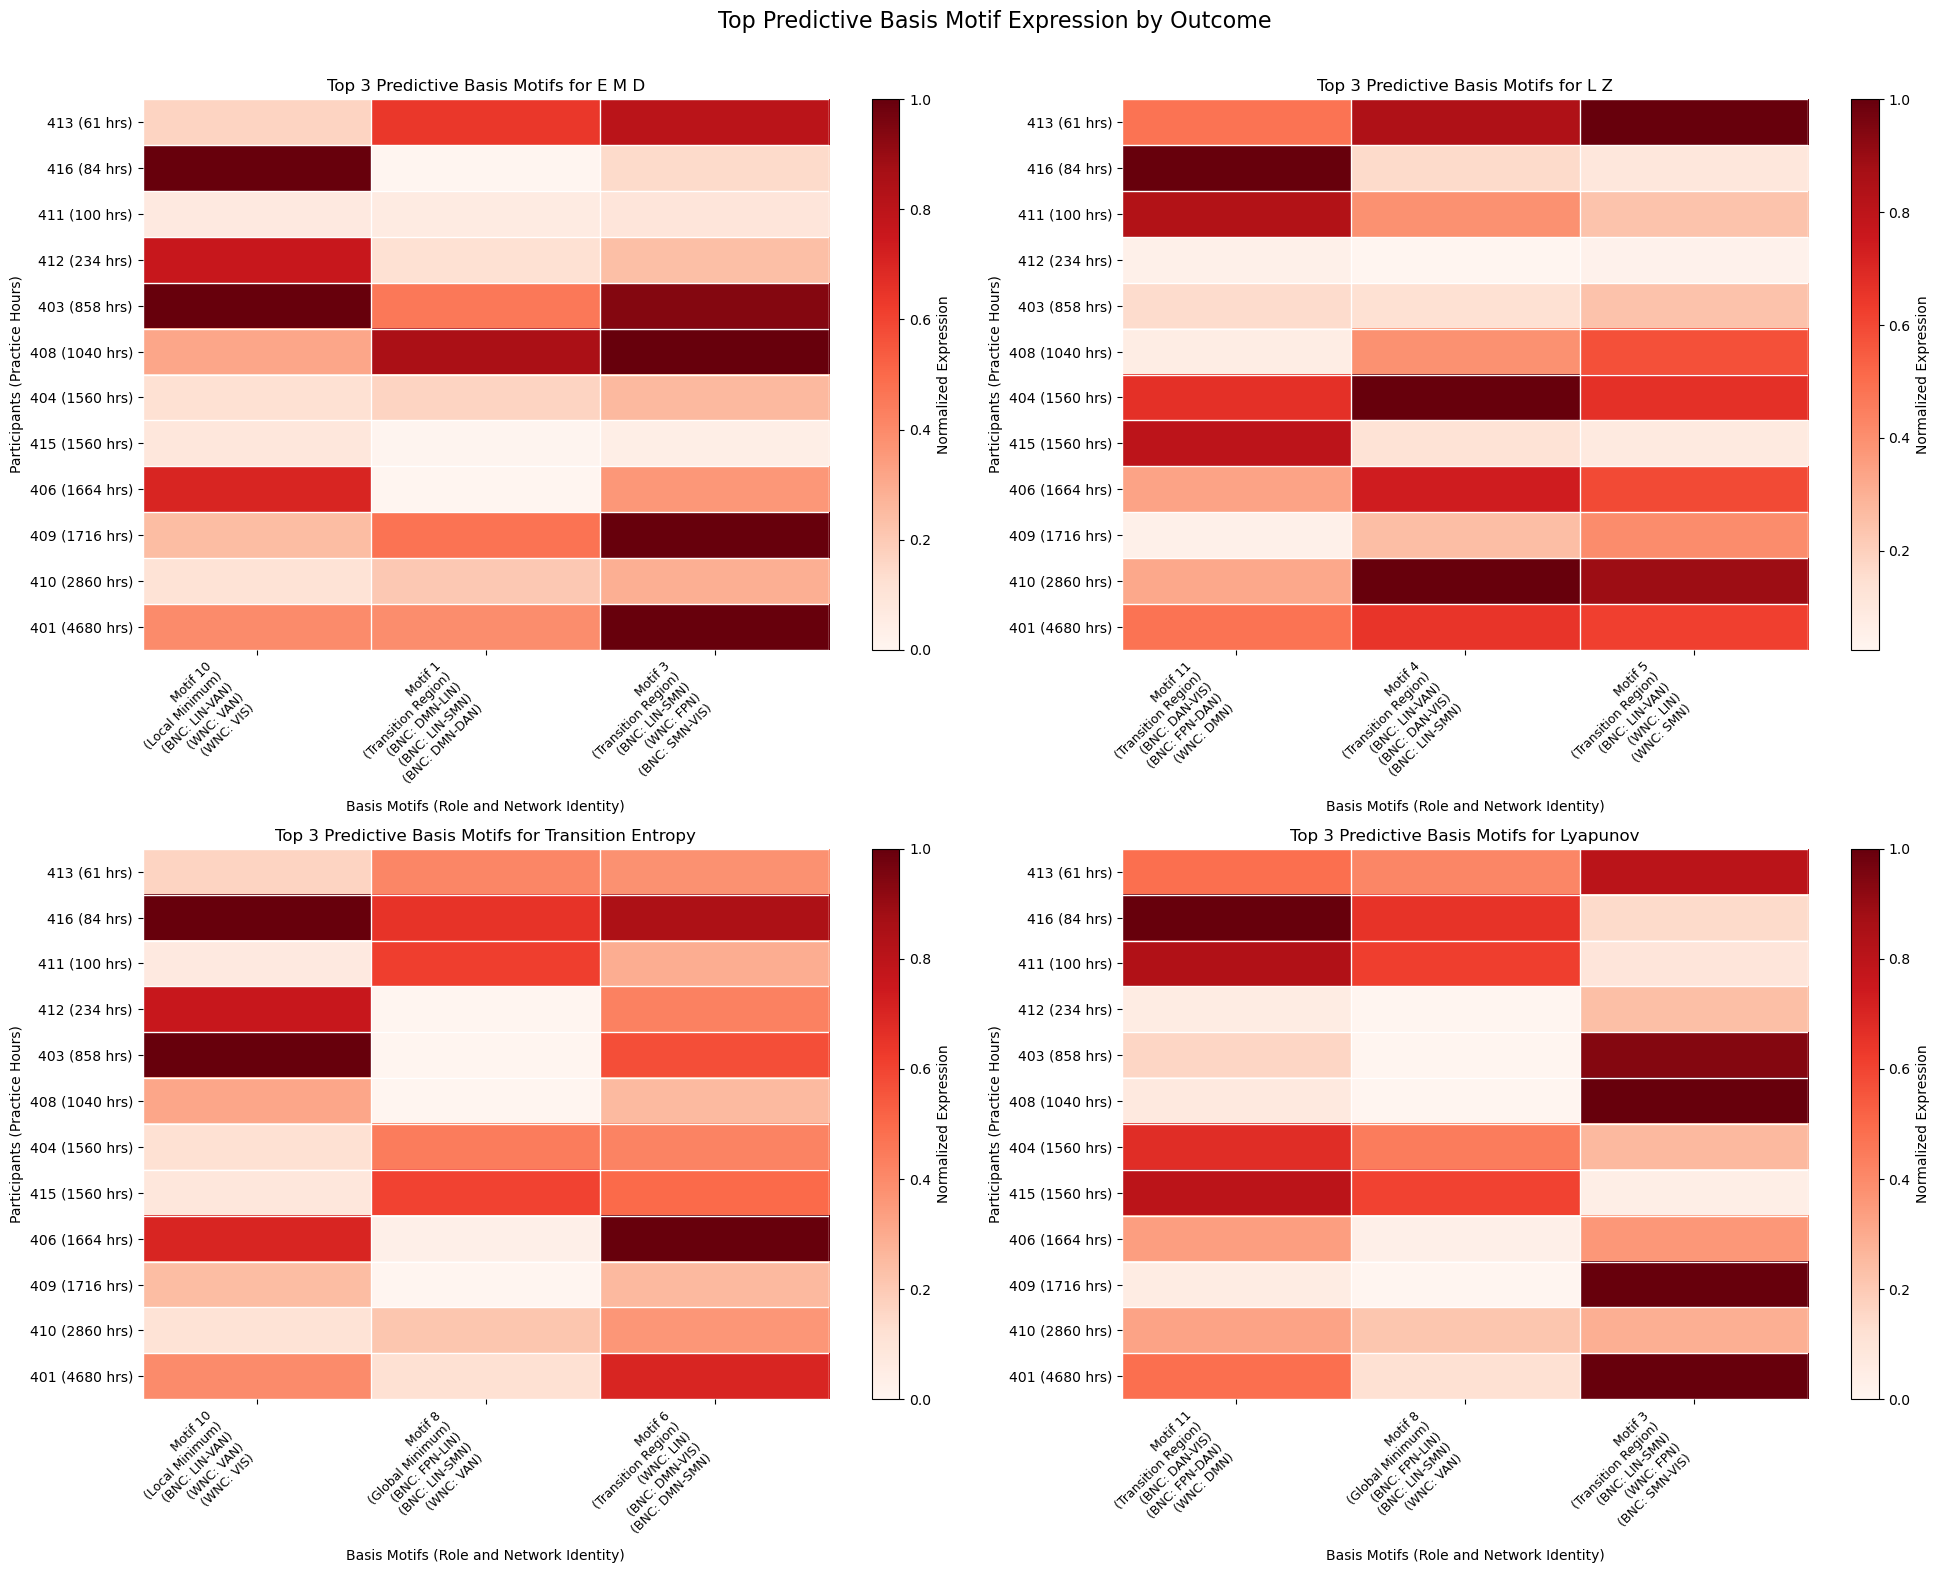

In [8]:
# Basis Motif Identity Heatmap Generator per Outcome w/ Flexible Plotting --> need to fix

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
from collections import defaultdict

# Create output directory
output_dir = 'top_motifs_analysis'
os.makedirs(output_dir, exist_ok=True)

# Network name abbreviation mapping
NETWORK_ABBREVIATIONS = {
    'Default': 'DMN',
    'Frontoparietal': 'FPN',
    'VentralAttention': 'VAN',
    'DorsalAttention': 'DAN',
    'Somatomotor': 'SMN',
    'Visual': 'VIS',
    'Limbic': 'LIN'
}

def abbreviate_network_identity(identity):
    """Convert network identity to abbreviated format"""
    if identity == "Unknown":
        return "Unknown"
    
    # Replace "within_" with "WNC" and "between_" with "BNC"
    if identity.startswith('within_'):
        network = identity.replace('within_', '')
        # Apply network abbreviation
        if network in NETWORK_ABBREVIATIONS:
            return f"WNC: {NETWORK_ABBREVIATIONS[network]}"
        return f"WNC: {network}"
    
    elif identity.startswith('between_'):
        # Extract the two networks
        networks = identity.replace('between_', '').split('_')
        if len(networks) == 2:
            net1, net2 = networks
            # Apply network abbreviations
            if net1 in NETWORK_ABBREVIATIONS:
                net1 = NETWORK_ABBREVIATIONS[net1]
            if net2 in NETWORK_ABBREVIATIONS:
                net2 = NETWORK_ABBREVIATIONS[net2]
            return f"BNC: {net1}-{net2}"
        return f"BNC: {identity.replace('between_', '')}"
    
    return identity

def load_trajectory_data(file_path='energy_landscape_results/trajectory_data.pkl'):
    """Load the trajectory data containing topological roles and expression data"""
    print(f"Loading trajectory data from {file_path}...")
    try:
        with open(file_path, 'rb') as f:
            trajectory_data = pickle.load(f)
        print("Successfully loaded trajectory data")
        return trajectory_data
    except Exception as e:
        print(f"Error loading trajectory data: {e}")
        return None

def load_basis_identities_with_scores(file_path='basis_motif_identities/basis_motif_identities.pkl'):
    """Load the basis motif network identities with full matching scores"""
    print(f"Loading basis motif identities from {file_path}...")
    try:
        with open(file_path, 'rb') as f:
            identity_data = pickle.load(f)
        # Fix these lines to use the correct keys
        basis_identities = identity_data.get('identities', {})
        matching_scores = identity_data.get('scores', {})
        print(f"Successfully loaded {len(basis_identities)} basis motif identities")
        
        # Check if we have full matching scores
        if matching_scores:
            print(f"Found full matching scores for {len(matching_scores)} motifs")
        else:
            print("Full matching scores not found, will use primary/secondary identities only")
            
        return basis_identities, matching_scores
    except Exception as e:
        print(f"Error loading basis identities: {e}")
        return {}, {}
    
def get_top_n_identities(motif, basis_identities, matching_scores, n=1):
    """Get the top N network identities for a given motif"""
    identities = []
    
    # Try to get from matching_scores first (full list)
    if motif in matching_scores and matching_scores[motif]:
        # matching_scores contains (template_name, score) tuples for each motif
        sorted_scores = matching_scores[motif]
        for i in range(min(n, len(sorted_scores))):
            if i < len(sorted_scores):
                template_name, _ = sorted_scores[i]
                identities.append(abbreviate_network_identity(template_name))
    
    # If we don't have enough, try to get from basis_identities
    if len(identities) < n and motif in basis_identities:
        motif_data = basis_identities[motif]
        
        # Add primary identity if not already added
        if 'primary_identity' in motif_data and len(identities) < n:
            primary_id = abbreviate_network_identity(motif_data['primary_identity'])
            if primary_id not in identities:
                identities.append(primary_id)
        
        # Add secondary identity if available and not already added
        if 'secondary_identity' in motif_data and motif_data['secondary_identity'] and len(identities) < n:
            secondary_id = abbreviate_network_identity(motif_data['secondary_identity'])
            if secondary_id not in identities and secondary_id != "Unknown":
                identities.append(secondary_id)
    
    # Ensure we have n identities by padding with "Unknown" if necessary
    while len(identities) < n:
        identities.append("Unknown")
    
    return identities[:n]  # Return at most n identities

def load_rf_results(file_path='non_linear_motif_analysis/rf_results.pkl'):
    """Load the Random Forest analysis results with structured data"""
    print(f"Loading Random Forest results from {file_path}...")
    try:
        with open(file_path, 'rb') as f:
            rf_results = pickle.load(f)
        
        # Check that we have the expected data structure
        outcomes = rf_results.keys()
        print(f"Successfully loaded results for {len(outcomes)} outcomes: {', '.join(outcomes)}")
        
        # Extract top motifs from each outcome
        top_motifs_by_outcome = {}
        for outcome, results in rf_results.items():
            if 'top_3_motifs' in results:
                top_motifs_by_outcome[outcome] = results['top_3_motifs']
                print(f"  Top 3 motifs for {outcome}: {results['top_3_motifs']}")
            else:
                print(f"  Warning: No top_3_motifs found for {outcome}")
        
        return top_motifs_by_outcome
    except Exception as e:
        print(f"Error loading Random Forest results: {e}")
        # Try the text file parsing as fallback
        print("Trying fallback method of parsing results.txt...")
        return extract_top_motifs_from_results()

def extract_top_motifs_from_results(file_path='non_linear_motif_analysis/results.txt'):
    """Extract the top 3 motifs for each outcome from the results file (fallback method)"""
    print(f"Extracting top motifs from {file_path}...")
    if not os.path.exists(file_path):
        print(f"Error: Results file not found at {file_path}")
        return {}

    try:
        with open(file_path, 'r') as f:
            content = f.read()

        # Look for explicit top 3 motifs first
        top_motifs_by_outcome = {}
        outcomes = ['EMD_age_adjusted', 'LZ_age_adjusted', 
                    'TransitionEntropy_age_adjusted', 'Lyapunov_age_adjusted']
        
        # First try to find the explicit "Top 3 motifs" entries
        for outcome in outcomes:
            pattern = f"Results for {outcome}:.*?Top 3 motifs: \[(.*?)\]"
            match = re.search(pattern, content, re.DOTALL)
            
            if match:
                # Parse the comma-separated list of motifs
                motifs_str = match.group(1)
                try:
                    # Convert string representation to actual list of integers
                    motifs = [int(m.strip()) for m in motifs_str.split(',')]
                    top_motifs_by_outcome[outcome] = motifs
                    print(f"  Found top 3 motifs for {outcome}: {motifs}")
                    continue
                except Exception as e:
                    print(f"  Error parsing explicit top motifs for {outcome}: {e}")
            
            # Fallback to parsing importance values
            pattern = f"Results for {outcome}:.*?Average Permutation Importances:(.*?)Stable Features"
            match = re.search(pattern, content, re.DOTALL)
            
            if not match:
                print(f"  Could not find permutation importance section for {outcome}")
                continue
                
            importance_section = match.group(1)
            
            # Extract motif indices and importance scores
            importances = []
            pattern = r"\s+basis_motif_(\d+): Importance = (\d+\.\d+)"
            
            for match in re.finditer(pattern, importance_section):
                motif_idx = int(match.group(1))
                importance = float(match.group(2))
                importances.append((motif_idx, importance))
            
            # Sort by importance and get top 3
            importances.sort(key=lambda x: x[1], reverse=True)
            top_3 = importances[:3]
            
            top_motifs_by_outcome[outcome] = [idx for idx, _ in top_3]
            print(f"  Parsed top 3 motifs for {outcome} via importances: {top_motifs_by_outcome[outcome]}")
            
        return top_motifs_by_outcome
        
    except Exception as e:
        print(f"Error extracting top motifs: {e}")
        return {}

def load_practice_hours(file_path=None):
    """Load practice hours data with fallback to multiple possible file paths"""
    potential_paths = [
        'practice_hours.csv',
        'practice_hours.xlsx',
        'Participant Experience - TCOA 401-416.xlsx',
        '/home/cerna3/neuroconn/Datasets_and_raw_data/Participant Experience - TCOA 401-416.xlsx',
        'efficiency_analysis_results/energy_landscape_metrics_age_adjusted.csv'
    ]
    
    if file_path:
        potential_paths.insert(0, file_path)
        
    for path in potential_paths:
        print(f"Trying to load practice hours from {path}...")
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        try:
            if path.endswith('.csv'):
                df = pd.read_csv(path)
                if 'participant_id' in df.columns and 'practice_hours' in df.columns:
                    practice_hours = df.set_index('participant_id')['practice_hours'].to_dict()
                    print(f"Successfully loaded practice hours for {len(practice_hours)} participants")
                    return practice_hours
            elif path.endswith('.xlsx'):
                df = pd.read_excel(path)
                if 'ID' in df.columns and 'Experience' in df.columns:
                    practice_hours = {}
                    for _, row in df.iterrows():
                        participant_id = str(int(row['ID']))
                        if len(participant_id) < 3:
                            participant_id = participant_id.zfill(3)
                        practice_hours[participant_id] = float(row['Experience'])
                    print(f"Successfully loaded practice hours for {len(practice_hours)} participants")
                    return practice_hours
        except Exception as e:
            print(f"Error loading from {path}: {e}")
            
    print("Warning: Could not load practice hours from any file. Using simulation.")
    practice_hours = {}
    for i in range(1, 17):
        if i == 5:  # Skip 405
            continue
        participant_id = f"4{i:02d}"
        practice_hours[participant_id] = 300 + i*300 + np.random.normal(0, 200)
    
    return practice_hours

def get_user_input_for_top_n_motifs():
    """Ask user how many top motifs to show for each outcome"""
    while True:
        try:
            print("\nHow many top motifs would you like to show for each outcome?")
            n = int(input("Enter a number (1-3): "))
            if 1 <= n <= 3:
                return n
            else:
                print("Please enter a number between 1 and 3.")
        except ValueError:
            print("Invalid input. Please enter a number between 1 and 3.")

def get_user_input_for_top_n_identities():
    """Ask user how many network identities to show for each motif"""
    while True:
        try:
            print("\nHow many network identities would you like to show for each motif?")
            n = int(input("Enter a number (1-3): "))
            if 1 <= n <= 3:
                return n
            else:
                print("Please enter a number between 1 and 3.")
        except ValueError:
            print("Invalid input. Please enter a number between 1 and 3.")

def filter_top_motifs(top_motifs_by_outcome, num_top_motifs):
    """Filter the top motifs based on user input"""
    filtered = {}
    for outcome, motifs in top_motifs_by_outcome.items():
        filtered[outcome] = motifs[:num_top_motifs]
    return filtered

def create_motif_label(motif, topological_metrics, basis_identities, matching_scores, num_identities):
    """Create a formatted label for a motif with multiple network identities"""
    # Get topological role
    topo_role = "Unknown"
    if motif in topological_metrics:
        topo_role = topological_metrics[motif].get('topological_role', 'Unknown')
    
    # Get top N network identities
    identities = get_top_n_identities(motif, basis_identities, matching_scores, num_identities)
    
    # Create the label
    label = [f"Motif {motif+1}", f"({topo_role})"]
    for identity in identities:
        label.append(f"({identity})")
    
    return "\n".join(label)

def create_top_motifs_heatmap(top_motifs_by_outcome, trajectory_data, basis_identities, matching_scores, 
                              practice_hours, num_identities):
    """Create a heatmap showing expression of top motifs for each outcome"""
    print("Creating top motifs heatmap...")
    
    if not top_motifs_by_outcome or not trajectory_data or not basis_identities or not practice_hours:
        print("Error: Missing required data for heatmap creation")
        return
    
    # Extract required data
    topological_metrics = trajectory_data.get('topological_metrics', {})
    tcoa_results = trajectory_data.get('tcoa_results', {})
    basis_expression_by_participant = tcoa_results.get('basis_expression_by_participant', {})
    
    # Identify all unique top motifs across outcomes
    all_top_motifs = set()
    for outcome, motifs in top_motifs_by_outcome.items():
        all_top_motifs.update(motifs)
    all_top_motifs = sorted(list(all_top_motifs))
    
    # Filter participants with both expression data and practice hours
    common_participants = sorted(
        [p for p in basis_expression_by_participant if p in practice_hours],
        key=lambda p: practice_hours[p]
    )
    
    if not common_participants:
        print("Error: No overlap between expression data and practice hours")
        return
    
    # Build the expression matrix
    expression_matrix = np.zeros((len(common_participants), len(all_top_motifs)))
    for i, participant in enumerate(common_participants):
        for j, motif in enumerate(all_top_motifs):
            expression_matrix[i, j] = basis_expression_by_participant[participant].get(motif, 0)
    
    # Prepare x-axis labels with topological role and multiple network identities
    x_labels = []
    for motif in all_top_motifs:
        x_labels.append(create_motif_label(motif, topological_metrics, basis_identities, 
                                          matching_scores, num_identities))
    
    # Prepare y-axis labels with participant ID and practice hours
    y_labels = [f"{p} ({practice_hours[p]:.0f} hrs)" for p in common_participants]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(max(14, len(all_top_motifs)*2.5), 10))
    
    # Plot heatmap
    cmap = plt.cm.Reds
    im = ax.imshow(expression_matrix,
                   cmap=cmap,
                   aspect='auto',
                   extent=[-0.5, len(all_top_motifs) - 0.5,
                           len(common_participants) - 0.5, -0.5])
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(all_top_motifs)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
    ax.set_yticks(np.arange(len(common_participants)))
    ax.set_yticklabels(y_labels)
    
    # Add grid
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks(np.arange(-0.5, len(all_top_motifs)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(common_participants)), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Normalized Expression')
    
    # Add outcome information
    outcome_info = []
    for outcome, motifs in top_motifs_by_outcome.items():
        # Format outcome name for display
        display_name = outcome.replace('_age_adjusted', '')
        display_name = ' '.join(re.findall('[A-Z][a-z]*', display_name)) or outcome
            
        motif_names = [f"Motif {m+1}" for m in motifs]
        outcome_info.append(f"{display_name}: {', '.join(motif_names)}")
    
    outcome_text = "\n".join(outcome_info)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.05, outcome_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='bottom', bbox=props)
    
    # Set title and labels
    ax.set_title('Top Predictive Basis Motif Expression by Practice Experience', fontsize=14)
    ax.set_xlabel('Basis Motifs (Role and Network Identity)', fontsize=12)
    ax.set_ylabel('Participants (Practice Hours)', fontsize=12)
    
    # Save and show figure
    plt.tight_layout()
    fig_path = os.path.join(output_dir, 'top_motifs_expression_heatmap.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved heatmap to: {fig_path}")
    
    return fig

def create_outcome_specific_heatmaps(top_motifs_by_outcome, trajectory_data, basis_identities, 
                                     matching_scores, practice_hours, num_identities):
    """Create separate heatmaps for each outcome's top motifs"""
    print("Creating outcome-specific heatmaps...")
    
    if not top_motifs_by_outcome or not trajectory_data or not basis_identities or not practice_hours:
        print("Error: Missing required data for heatmap creation")
        return
    
    # Extract required data
    topological_metrics = trajectory_data.get('topological_metrics', {})
    tcoa_results = trajectory_data.get('tcoa_results', {})
    basis_expression_by_participant = tcoa_results.get('basis_expression_by_participant', {})
    
    # Filter participants with both expression data and practice hours
    common_participants = sorted(
        [p for p in basis_expression_by_participant if p in practice_hours],
        key=lambda p: practice_hours[p]
    )
    
    if not common_participants:
        print("Error: No overlap between expression data and practice hours")
        return
    
    for outcome, motifs in top_motifs_by_outcome.items():
        if not motifs:
            continue
            
        # Build the expression matrix for this outcome's top motifs
        expression_matrix = np.zeros((len(common_participants), len(motifs)))
        for i, participant in enumerate(common_participants):
            for j, motif in enumerate(motifs):
                expression_matrix[i, j] = basis_expression_by_participant[participant].get(motif, 0)
        
        # Prepare x-axis labels with both topological role and network identity
        x_labels = []
        for motif in motifs:
            x_labels.append(create_motif_label(motif, topological_metrics, basis_identities, 
                                              matching_scores, num_identities))
        
        # Prepare y-axis labels with participant ID and practice hours
        y_labels = [f"{p} ({practice_hours[p]:.0f} hrs)" for p in common_participants]
        
        # Create figure
        fig, ax = plt.subplots(figsize=(max(10, len(motifs)*3), 10))
        
        # Plot heatmap
        cmap = plt.cm.Reds
        im = ax.imshow(expression_matrix,
                      cmap=cmap,
                      aspect='auto',
                      extent=[-0.5, len(motifs) - 0.5,
                              len(common_participants) - 0.5, -0.5])
        
        # Set ticks and labels
        ax.set_xticks(np.arange(len(motifs)))
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
        ax.set_yticks(np.arange(len(common_participants)))
        ax.set_yticklabels(y_labels)
        
        # Add grid
        for edge, spine in ax.spines.items():
            spine.set_visible(False)
        ax.set_xticks(np.arange(-0.5, len(motifs)), minor=True)
        ax.set_yticks(np.arange(-0.5, len(common_participants)), minor=True)
        ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
        ax.tick_params(which='minor', bottom=False, left=False)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Normalized Expression')
        
        # Format outcome name for display
        display_name = outcome.replace('_age_adjusted', '')
        display_name = ' '.join(re.findall('[A-Z][a-z]*', display_name)) or outcome
        
        # Get the number of top motifs
        num_motifs = len(motifs)
        
        # Set title and labels
        ax.set_title(f'Top {num_motifs} Predictive Basis Motifs for {display_name}', fontsize=14)
        ax.set_xlabel('Basis Motifs (Role and Network Identity)', fontsize=12)
        ax.set_ylabel('Participants (Practice Hours)', fontsize=12)
        
        # Save figure
        plt.tight_layout()
        fig_path = os.path.join(output_dir, f'top_motifs_{outcome}.png')
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"Saved {outcome} heatmap to: {fig_path}")
        plt.close(fig)

def create_combined_figure(top_motifs_by_outcome, trajectory_data, basis_identities, 
                           matching_scores, practice_hours, num_identities):
    """Create a 2x2 grid of heatmaps, one for each outcome"""
    print("Creating combined 2x2 heatmap figure...")
    
    if not top_motifs_by_outcome or not trajectory_data or not basis_identities or not practice_hours:
        print("Error: Missing required data for heatmap creation")
        return
    
    # Extract required data
    topological_metrics = trajectory_data.get('topological_metrics', {})
    tcoa_results = trajectory_data.get('tcoa_results', {})
    basis_expression_by_participant = tcoa_results.get('basis_expression_by_participant', {})
    
    # Filter participants with both expression data and practice hours
    common_participants = sorted(
        [p for p in basis_expression_by_participant if p in practice_hours],
        key=lambda p: practice_hours[p]
    )
    
    if not common_participants:
        print("Error: No overlap between expression data and practice hours")
        return
    
    # Define outcomes and their positions in the 2x2 grid
    grid_positions = {
        'EMD_age_adjusted': (0, 0),
        'LZ_age_adjusted': (0, 1),
        'TransitionEntropy_age_adjusted': (1, 0),
        'Lyapunov_age_adjusted': (1, 1)
    }
    
    # Create figure with 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    for outcome, (row, col) in grid_positions.items():
        if outcome not in top_motifs_by_outcome:
            print(f"Warning: No data for {outcome}")
            continue
            
        motifs = top_motifs_by_outcome[outcome]
        if not motifs:
            continue
            
        # Get current axis
        ax = axes[row, col]
        
        # Build the expression matrix for this outcome's top motifs
        expression_matrix = np.zeros((len(common_participants), len(motifs)))
        for i, participant in enumerate(common_participants):
            for j, motif in enumerate(motifs):
                expression_matrix[i, j] = basis_expression_by_participant[participant].get(motif, 0)
        
        # Prepare x-axis labels with both topological role and network identity
        x_labels = []
        for motif in motifs:
            x_labels.append(create_motif_label(motif, topological_metrics, basis_identities, 
                                              matching_scores, num_identities))
        
        # Prepare y-axis labels with participant ID and practice hours
        y_labels = [f"{p} ({practice_hours[p]:.0f} hrs)" for p in common_participants]
        
        # Plot heatmap
        cmap = plt.cm.Reds
        im = ax.imshow(expression_matrix,
                      cmap=cmap,
                      aspect='auto',
                      extent=[-0.5, len(motifs) - 0.5,
                              len(common_participants) - 0.5, -0.5])
        
        # Set ticks and labels
        ax.set_xticks(np.arange(len(motifs)))
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
        ax.set_yticks(np.arange(len(common_participants)))
        ax.set_yticklabels(y_labels)
        
        # Add grid
        for edge, spine in ax.spines.items():
            spine.set_visible(False)
        ax.set_xticks(np.arange(-0.5, len(motifs)), minor=True)
        ax.set_yticks(np.arange(-0.5, len(common_participants)), minor=True)
        ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
        ax.tick_params(which='minor', bottom=False, left=False)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Normalized Expression')
        
        # Format outcome name for display
        display_name = outcome.replace('_age_adjusted', '')
        display_name = ' '.join(re.findall('[A-Z][a-z]*', display_name)) or outcome
            
        # Get the number of top motifs
        num_motifs = len(motifs)
        
        # Set title and labels
        ax.set_title(f'Top {num_motifs} Predictive Basis Motifs for {display_name}', fontsize=12)
        ax.set_xlabel('Basis Motifs (Role and Network Identity)', fontsize=10)
        ax.set_ylabel('Participants (Practice Hours)', fontsize=10)
    
    # Set overall title
    plt.suptitle('Top Predictive Basis Motif Expression by Outcome', fontsize=16)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for suptitle
    fig_path = os.path.join(output_dir, 'combined_top_motifs_heatmap.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved combined heatmap to: {fig_path}")
    
    return fig

def main():
    """Main function to orchestrate the heatmap creation process"""
    print("\n" + "="*80)
    print("TOP PREDICTIVE BASIS MOTIFS HEATMAP GENERATOR")
    print("="*80)
    
    # Load all required data
    trajectory_data = load_trajectory_data()
    basis_identities, matching_scores = load_basis_identities_with_scores()
    
    # Attempt to load RF results from structured pickle file first
    top_motifs_by_outcome = load_rf_results()
    
    # If that fails, try the text file fallback method
    if not top_motifs_by_outcome:
        print("Warning: Could not load structured results, falling back to text parsing...")
        top_motifs_by_outcome = extract_top_motifs_from_results()
    
    practice_hours = load_practice_hours()
    
    # Get user input for number of top motifs to display
    num_top_motifs = get_user_input_for_top_n_motifs()
    print(f"\nShowing top {num_top_motifs} motifs for each outcome.")
    
    # Get user input for number of network identities to display
    num_identities = get_user_input_for_top_n_identities()
    print(f"\nShowing top {num_identities} network identities for each motif.")
    
    # Filter motifs based on user input
    filtered_motifs = filter_top_motifs(top_motifs_by_outcome, num_top_motifs)
    
    # Create heatmaps
    create_top_motifs_heatmap(filtered_motifs, trajectory_data, basis_identities, matching_scores, 
                              practice_hours, num_identities)
    create_outcome_specific_heatmaps(filtered_motifs, trajectory_data, basis_identities, matching_scores, 
                                    practice_hours, num_identities)
    create_combined_figure(filtered_motifs, trajectory_data, basis_identities, matching_scores, 
                          practice_hours, num_identities)
    
    print("\n" + "="*80)
    print("HEATMAP GENERATION COMPLETE")
    print("="*80)
    print(f"Results saved to {os.path.abspath(output_dir)}")

if __name__ == "__main__":
    main()